In [35]:
import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import seaborn as sns

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [36]:

class Model(nn.Module):
    def __init__(self, num_features, width, depth):
        super().__init__()
        layers = [
            nn.Linear(num_features, width),
            nn.ReLU(),
        ]
        for i in range(depth-1):
            layers.extend([
                nn.Linear(width, width),
                nn.ReLU(),
            ])
        layers.append(nn.Linear(width, 1))

        self.nn_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.nn_stack(x)        
        return logits
        
        
        
def train(features, labels, model, loss_fn, optimizer, batch_size=1000):
    size = len(features)
    num_batches = size // batch_size + int(size / batch_size > 0)
    
    model.train()
    for batch in range(num_batches):
        idx = slice(batch*batch_size, (batch+1)*batch_size)
        X = features[idx]
        y = labels[idx]
    
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")   


def test(features, labels, model, loss_fn):    
    model.eval()
    with torch.no_grad():
        X, y = features.to(device), labels.to(device)
        pred = model(X)
        test_loss = loss_fn(pred, y).item()    
        correct = (pred.argmax(1) == y).type(torch.float).sum().item() / len(y)          
    return test_loss, correct
    



In [37]:
df = pd.read_parquet('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/wasting/training_data/2024_07_17.01/data.parquet')
features = [
    'ldi_pc_pd',
    'days_over_30C',    
]
X_raw = torch.tensor(df[features].values, dtype=torch.float32)
#mu, sigma = 0, torch.tensor(np.percentile(X_raw, 99, axis=0))
#mu, sigma = 0, X_raw.max(0) 
mu, sigma = X_raw.mean(0), X_raw.std(0)
X = (X_raw - X_raw.mean(0)) / X_raw.std(0)
y = torch.tensor(df['cgf_value'].values, dtype=torch.int64)
m = Model(len(features), 10, 3).to(device)
loss = nn.BCELoss()
optimizer = torch.optim.AdamW(m.parameters(), lr=3e-4,)


split = int(0.8*len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

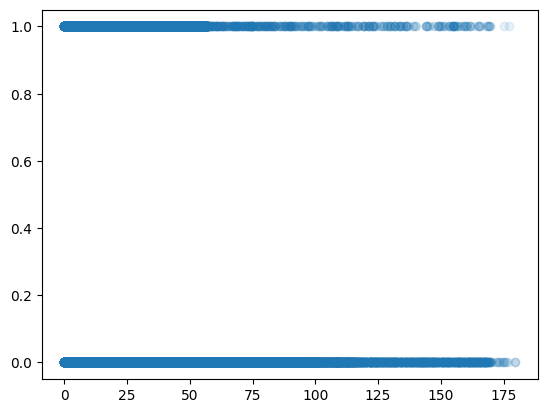

In [41]:
plt.scatter(df['ldi_pc_pd'], df['cgf_value'], alpha=0.1)

In [4]:
# torch.tensor(np.percentile(X_raw, 99, axis=0))

In [5]:
sum([p.numel() for p in m.parameters()])

87

In [31]:
res = 250
ldi_plot = np.round(np.linspace(-10, 200, res), 1)
dat_plot = np.round(np.linspace(-5, 365, res), 0)
aa, bb = np.meshgrid(ldi_plot, dat_plot)
plot_tensor = torch.stack([torch.tensor(aa.flatten(), dtype=torch.float32), torch.tensor(bb.flatten(), dtype=torch.float32)], dim=1)
ptx = ((plot_tensor - mu) / sigma).to(device)
pred = m(ptx)
z = nn.Softmax(1)(pred)[:, 1].cpu().detach().numpy().reshape((res, res))



<Axes: xlabel='days_over_30C', ylabel='ldi_pc_pd'>

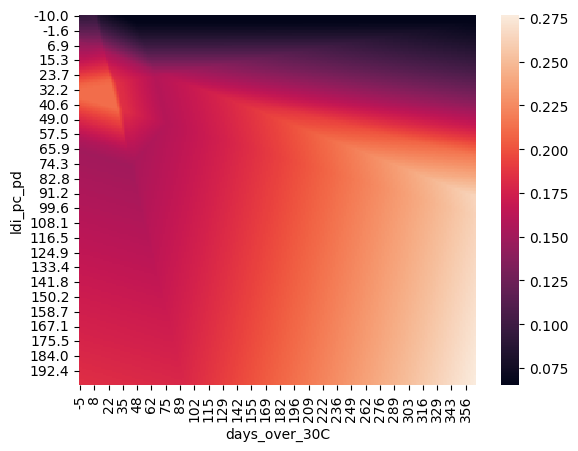

In [32]:
sns.heatmap(data=pd.DataFrame(z, index=pd.Series(ldi_plot, name='ldi_pc_pd'), columns=pd.Series(dat_plot.astype(int), name='days_over_30C')))

In [8]:
epochs = 10000
data = []
for t in tqdm.trange(epochs):    
    train(X_train, y_train, m, loss, optimizer, batch_size=100000)
    train_loss, train_correct = test(X_train, y_train, m, loss)
    test_loss, test_correct = test(X_test, y_test, m, loss)
    data.extend([
        (t, 'train', train_loss, train_correct),
        (t, 'test', test_loss, test_correct),
    ])
    # if t % 5 == 0:
    #     print(f"Epoch {t+1}\n-------------------------------")
    #     print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        
print("Done!")

100%|███████████████████████████████████████████████████████████| 10000/10000 [18:22<00:00,  9.07it/s]

Done!


<Axes: xlabel='epoch', ylabel='loss'>

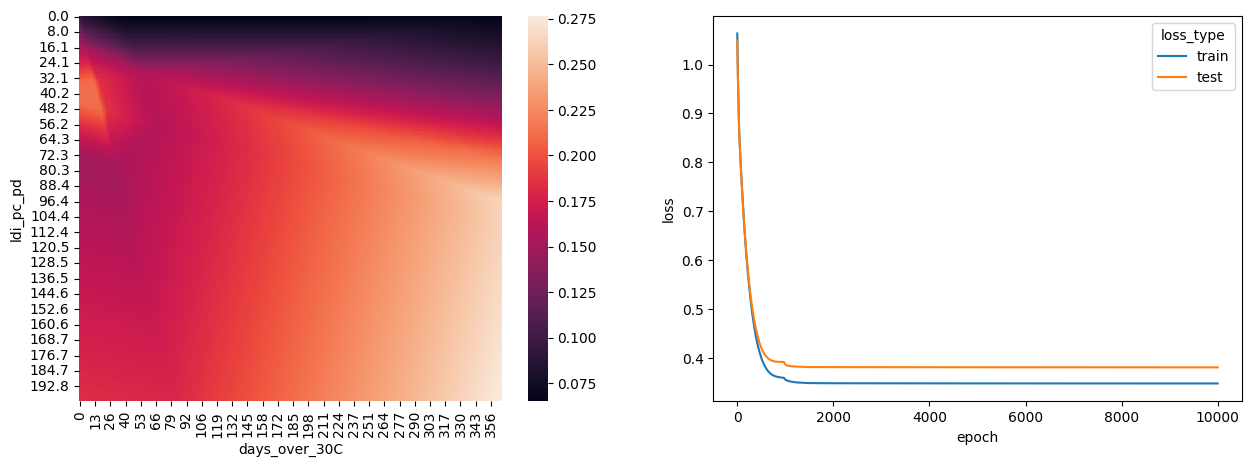

In [9]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
pred = m(ptx)
z = nn.Softmax(1)(pred)[:, 1].cpu().detach().numpy().reshape((res, res))
sns.heatmap(data=pd.DataFrame(z, index=pd.Series(ldi_plot, name='ldi_pc_pd'), columns=pd.Series(dat_plot.astype(int), name='days_over_30C')), ax=axes[0])

loss_df = pd.DataFrame(data, columns=['epoch', 'loss_type', 'loss', 'correct'])
sns.lineplot(x='epoch', y='loss', hue='loss_type', data=loss_df, ax=axes[1])

<Axes: xlabel='days_over_30', ylabel='ldi'>

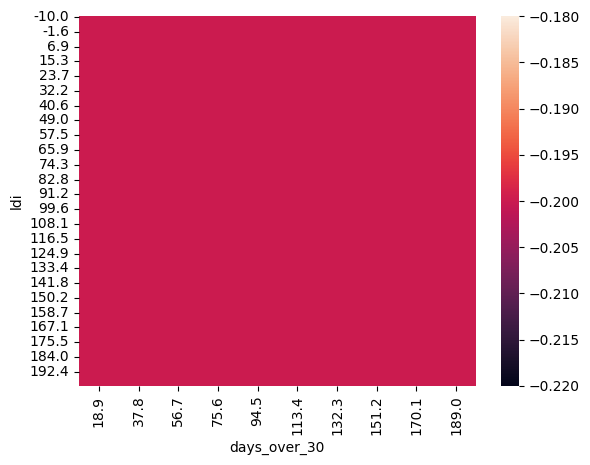

In [33]:
data = df.loc[df.ihme_loc_id == 'IND', features + ['cgf_value']]
data['ldi'] = pd.cut(data['ldi_pc_pd'], 10).apply(lambda x: x.right).astype(float)
data['days_over_30'] = pd.cut(data['days_over_30C'], 10).apply(lambda x: x.right).astype(float).fillna(0)
data = data.groupby(['ldi', 'days_over_30']).cgf_value.mean().unstack().reindex(ldi_plot).fillna(-0.2)
sns.heatmap(data)

In [34]:
data

days_over_30,18.9,37.8,56.7,75.6,94.5,113.4,132.3,151.2,170.1,189.0
ldi,,,,,,,,,,
-10.0,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2
-9.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2
-8.3,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2
-7.5,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2
-6.6,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2
...,...,...,...,...,...,...,...,...,...,...
196.6,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2
197.5,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2
198.3,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2,-0.2


<Axes: xlabel='ldi_pc_pd', ylabel='ihme_loc_id'>

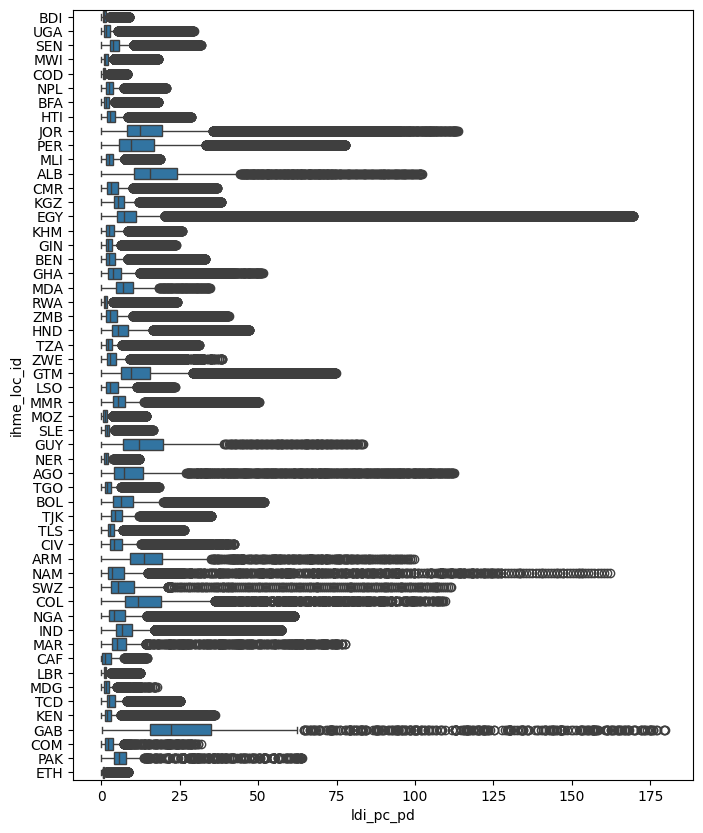

In [24]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(y='ihme_loc_id', x='ldi_pc_pd', data=df,ax=ax)

In [ ]:
X_raw.numpy()